In [1]:
import os
from glob import glob

import dask
import numpy as np
import xarray as xr

In [2]:
################
#### Paths #####
################
# Update these for reproduction

project_data_path = "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/"

In [7]:
def get_raw_data_loc(var_id, metric, lat, lon, years):
    #####################
    # Read all ensembles
    #####################
    # NEX-GDDP-CMIP6
    ds_nex = xr.open_dataset(f"{project_data_path}/NEX-GDDP-CMIP6_{ssp}_{years}.nc").assign_coords(ensemble='NEX-GDDP')

    # CIL-GDPCIR
    ds_cil = xr.open_dataset(f"{project_data_path}/CIL-GDPCIR_{ssp}_{years}.nc").assign_coords(ensemble='CIL-GDPCIR')
    ds_cil = ds_cil.rename({'pr_max':'max_pr', 'tas_avg':'avg_tas', 'pr_sum':'sum_pr', 'tasmax_max':'max_tasmax'})

    # LOCA2
    metrics = ['avg_tas', 'sum_pr', 'max_tasmax', 'max_pr']
    ds_loca = xr.merge([xr.open_dataset(f"{project_data_path}/LOCA2_{ssp}_{years}_{metric}.nc") for metric in metrics])
    ds_loca = ds_loca.assign_coords(ensemble='LOCA2')

    # Merge all
    ds = xr.concat([ds_nex, ds_loca, ds_cil], dim='ensemble')

    ###########################
    # Useful plotting funcs
    ###########################
    def tidy_ax(ax, p, title):
            # Tidy
            ax.coastlines()
            ax.set_title(title)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.set_extent([-120, -73, 21, 55], ccrs.Geodetic())
            # Colorbar
            fig.colorbar(p,
                         orientation="horizontal",
                         shrink = 0.9,
                         ax=ax,
                         pad=0.04)

    #############
    # Main plot
    #############
    ensembles = ['LOCA2', 'NEX-GDDP', 'CIL-GDPCIR']

    fig, axs = plt.subplots(3, 3, figsize=(12, 10),
                        gridspec_kw=dict(wspace=0.01, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

    # Iterate through all combinations
    for i1, ens1 in enumerate(ensembles):
        for i2, ens2 in enumerate(ensembles):
            # Set axis
            ax = axs[i1, i2]
            # DIAGONAL
            if i1 == i2:
                # Individual plot
                ds_plot = ds.sel(indice=indice, ensemble=ens1)[f"{metric}_{var_id}"]
                p = ds_plot.plot(ax=ax,
                                 vmin=vmin_ind, vmax=vmax_ind,
                                 cmap=cmap_ind, add_colorbar=False, levels=ind_levels,
                                 transform=ccrs.PlateCarree())
                # Tidy
                tidy_ax(ax, p, ens1)
            # OFF DIAGONAL MAP
            elif i1 > i2:
                # Difference plot
                ds_diff = ds.sel(indice=indice, ensemble=ens1)[f"{metric}_{var_id}"] - ds.sel(indice=indice, ensemble=ens2)[f"{metric}_{var_id}"]
                p = ds_diff.plot(ax=ax,
                                 vmin=-vdiff, vmax=vdiff,
                                 cmap=cmap_diff, add_colorbar=False, levels=diff_levels,
                                 transform=ccrs.PlateCarree())
                # Tidy
                tidy_ax(ax, p, f"{ens1} minus {ens2}")
            # OFF DIAGONAL DIST
            else:
                ax.axis('off')
    # Add suptitle
    fig.suptitle(suptitle, y=0.92, weight='bold')

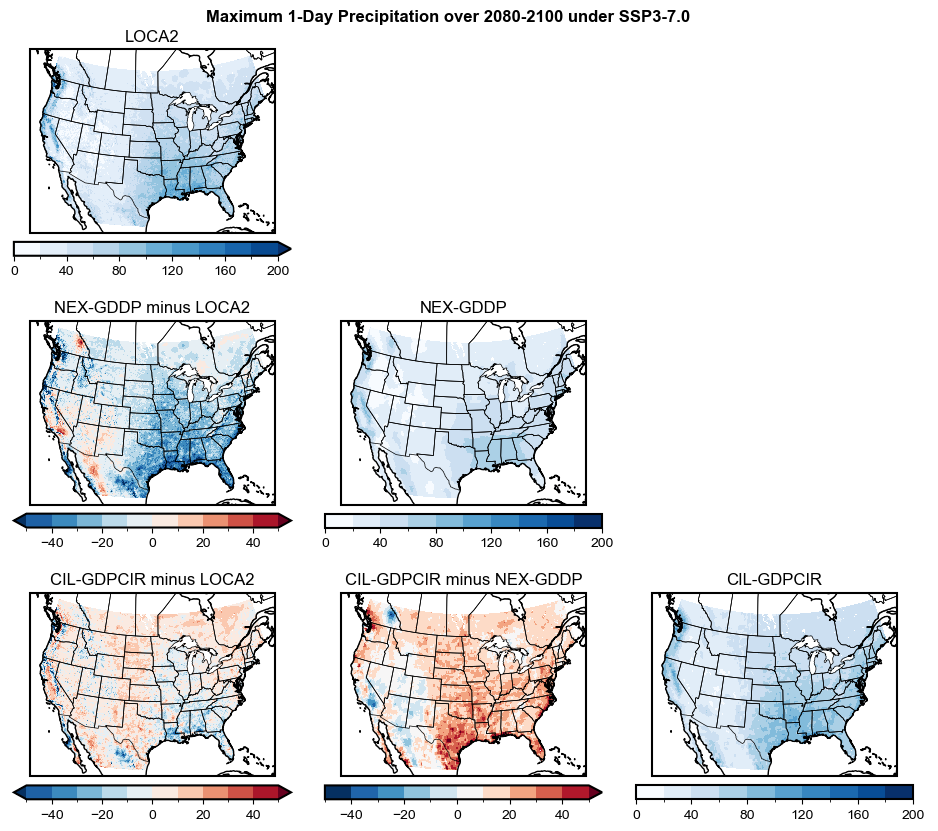

In [4]:
main_comparison_plot(ssp = 'ssp370',
                     years = '2080-2100',
                     var_id = 'pr',
                     metric = 'max',
                     indice = 'mean',
                     vmin_ind = 0.,
                     vmax_ind = 200.,
                     vdiff = 50.,
                     ind_levels = 11,
                     diff_levels = 11,
                     cmap_ind = 'Blues',
                     cmap_diff='RdBu_r',
                     suptitle = 'Maximum 1-Day Precipitation over 2080-2100 under SSP3-7.0')

In [8]:
def main_comparison_plot(ssp, years, var_id, metric, indice,
                         units, 
                         suptitle, 
                         vmin_ind, vmax_ind, vdiff,
                         ind_levels, diff_levels,
                         cmap_ind, cmap_diff='RdBu_r'):
    #####################
    # Read all ensembles
    #####################
    # NEX-GDDP-CMIP6
    ds_nex = xr.open_dataset(f"{project_data_path}/NEX-GDDP-CMIP6_{ssp}_{years}.nc").assign_coords(ensemble='NEX-GDDP')

    # CIL-GDPCIR
    ds_cil = xr.open_dataset(f"{project_data_path}/CIL-GDPCIR_{ssp}_{years}.nc").assign_coords(ensemble='CIL-GDPCIR')
    ds_cil = ds_cil.rename({'pr_max':'max_pr', 'tas_avg':'avg_tas', 'pr_sum':'sum_pr', 'tasmax_max':'max_tasmax'})

    # LOCA2
    metrics = ['avg_tas', 'sum_pr', 'max_tasmax', 'max_pr']
    ds_loca = xr.merge([xr.open_dataset(f"{project_data_path}/LOCA2_{ssp}_{years}_{metric}.nc") for metric in metrics])
    ds_loca = ds_loca.assign_coords(ensemble='LOCA2')

    # Merge all
    ds = xr.concat([ds_nex, ds_loca, ds_cil], dim='ensemble')

    ###########################
    # Useful plotting funcs
    ###########################
    def tidy_ax(ax, p, title):
            # Tidy
            ax.coastlines()
            ax.set_title(title)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.set_extent([-120, -73, 21, 55], ccrs.Geodetic())

    #############
    # Main plot
    #############
    ensembles = ['LOCA2', 'NEX-GDDP', 'CIL-GDPCIR']

    fig, axs = plt.subplots(2, 3, figsize=(12, 6),
                            gridspec_kw=dict(wspace=0.03, hspace=0.05),
                            subplot_kw=dict(projection=ccrs.LambertConformal()))

    # Iterate through all individual
    for ixe, ensemble in enumerate(ensembles):
        # Set axis
        ax = axs[0, ixe]
        # Individual plot
        ds_plot = ds.sel(indice=indice, ensemble=ensemble)[f"{metric}_{var_id}"]
        p = ds_plot.plot(ax=ax,
                         vmin=vmin_ind, vmax=vmax_ind,
                         cmap=cmap_ind, add_colorbar=False, levels=ind_levels,
                         transform=ccrs.PlateCarree())
        # Tidy
        tidy_ax(ax, p, ensemble)
    # Colorbar for first row
    cbar = fig.colorbar(p,
                 orientation="vertical",
                 shrink=0.8,
                 extend='neither',
                 aspect=15,
                 ax=axs[0,:],
                 pad=0.01)
    cbar.ax.set_ylabel(f'{indice.capitalize()} {units}', rotation=-90, va="bottom")
    
    # Iterate through all combination
    combos = [('LOCA2', 'NEX-GDDP'), ('LOCA2', 'CIL-GDPCIR'), ('NEX-GDDP', 'CIL-GDPCIR')]
    for ixe, ensemble in enumerate(combos):
        ax = axs[1, ixe]
        ens1, ens2 = ensemble
        # Difference plot
        ds_diff = ds.sel(indice=indice, ensemble=ens1)[f"{metric}_{var_id}"] - ds.sel(indice=indice, ensemble=ens2)[f"{metric}_{var_id}"]
        p = ds_diff.plot(ax=ax,
                         vmin=-vdiff, vmax=vdiff,
                         cmap=cmap_diff, add_colorbar=False, levels=diff_levels,
                         transform=ccrs.PlateCarree())
        # Tidy
        tidy_ax(ax, p, f"{ens1} minus {ens2}")
    # Colorbar for second row
    cbar = fig.colorbar(p,
                 orientation="vertical",
                 shrink=0.8,
                 extend='neither',
                 aspect=15,
                 ax=axs[1,:],
                 pad=0.01)
    cbar.ax.set_ylabel(f'Difference {units}', rotation=-90, va="bottom")
    # Add suptitle
    fig.suptitle(suptitle, x=0.45, y=0.94, weight='bold')

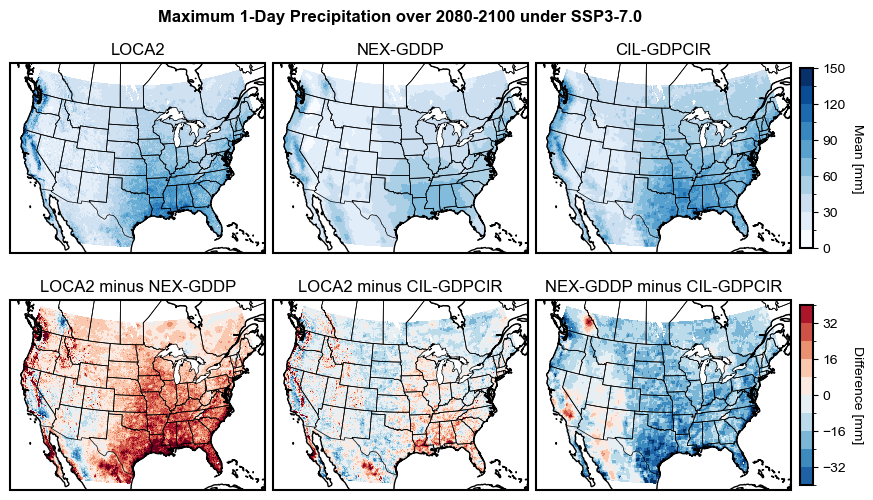

In [5]:
main_comparison_plot(ssp = 'ssp370',
                     years = '2080-2100',
                     var_id = 'pr',
                     metric = 'max',
                     indice = 'mean',
                     units = '[mm]',
                     vmin_ind = 0.,
                     vmax_ind = 150.,
                     vdiff = 40.,
                     ind_levels = 11,
                     diff_levels = 11,
                     cmap_ind = 'Blues',
                     cmap_diff = 'RdBu_r',
                     suptitle = 'Maximum 1-Day Precipitation over 2080-2100 under SSP3-7.0')